@Author: Ben Funk
TODO: Look at calibrating each sensor before analyzing the data

In [61]:
# Relevant libraries
import pandas as pd
import scipy.optimize as sc
import scipy.stats as st
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy.stats import f
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt



In [62]:
# Load data from CSV file
file2 = pd.read_csv("../Output/LowPPMMatrix.csv")
# Extract the columns from the data
#file2=file2[file2['Target PPM']<=500]

#file2=file2[file2['Target PPM']!=150]
#file2=file2[file2['SensorID']==7]
xDataResistance = file2.loc[:, 'Resistance']
xDataRatio = file2.loc[:, 'Ratio']
xDataRH = file2.loc[:, 'RelativeHumidity']
xDataTemp = file2.loc[:, 'Temperature']
yDataTargetPPM = file2.loc[:, 'Target PPM']

#calculate abso.lute humidity in g/m^3
P_actual_hPa = .8 * 1013.25
e_sat_standard = 6.112 * np.exp((17.67 * xDataTemp) / (xDataTemp + 243.5))
e_sat_actual = e_sat_standard * (P_actual_hPa / 1013.25)
xDataAH = 1000*((xDataRH/100)*e_sat_actual)/(461.5*(xDataTemp+ 273.15))

# Separate the independent and dependent variables
X = file2.drop('Target PPM', axis='columns')
y = file2.loc[:, 'Target PPM']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


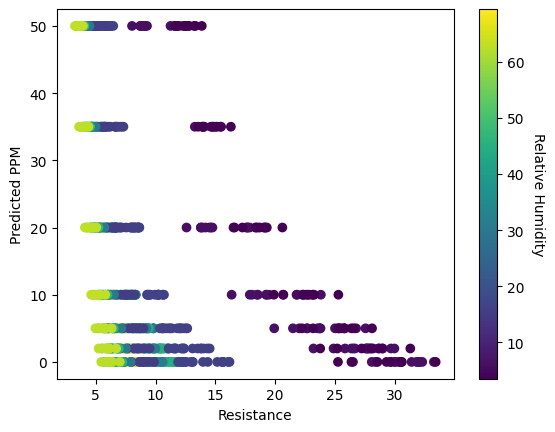

In [63]:
df = file2
# code to show data with relative humidity
scatter = plt.scatter(df.loc[:, 'Resistance'], df.loc[:, "Target PPM"], c=xDataRH)
plt.xlabel("Resistance")
plt.ylabel('Predicted PPM')
cbar = plt.colorbar(scatter)
cbar.set_label('Relative Humidity', rotation=270, labelpad=15)
plt.show()


# code to show data with absolute humidity
# scatter = plt.scatter(df.loc[:, 'Resistance'], df.loc[:, "Target PPM"], c=xDataAH)
# plt.xlabel("Resistance")
# plt.ylabel('Predicted PPM')
# cbar = plt.colorbar(scatter)
# cbar.set_label('absolute', rotation=270, labelpad=15)
# plt.show()

C:\Users\funkb\AppData\Local\Temp\ipykernel_3264\1298921324.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Predicted PPM'] = y_pred
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\funkb\AppData\Local\Temp\ipykernel_3264\1298921324.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Predicted PPM'] = y_pred
No artists with labels found to put in legend.  Not

[ 9.28890348e-01 -6.67188051e-01 -6.32613441e-01  4.51694602e-01
 -8.86005975e+00  2.99132427e+00  1.06839408e-02  2.99153912e+00
 -7.14093518e+01 -8.14992392e-16  1.87099690e+01 -3.32455194e+00]
5.644465924618867


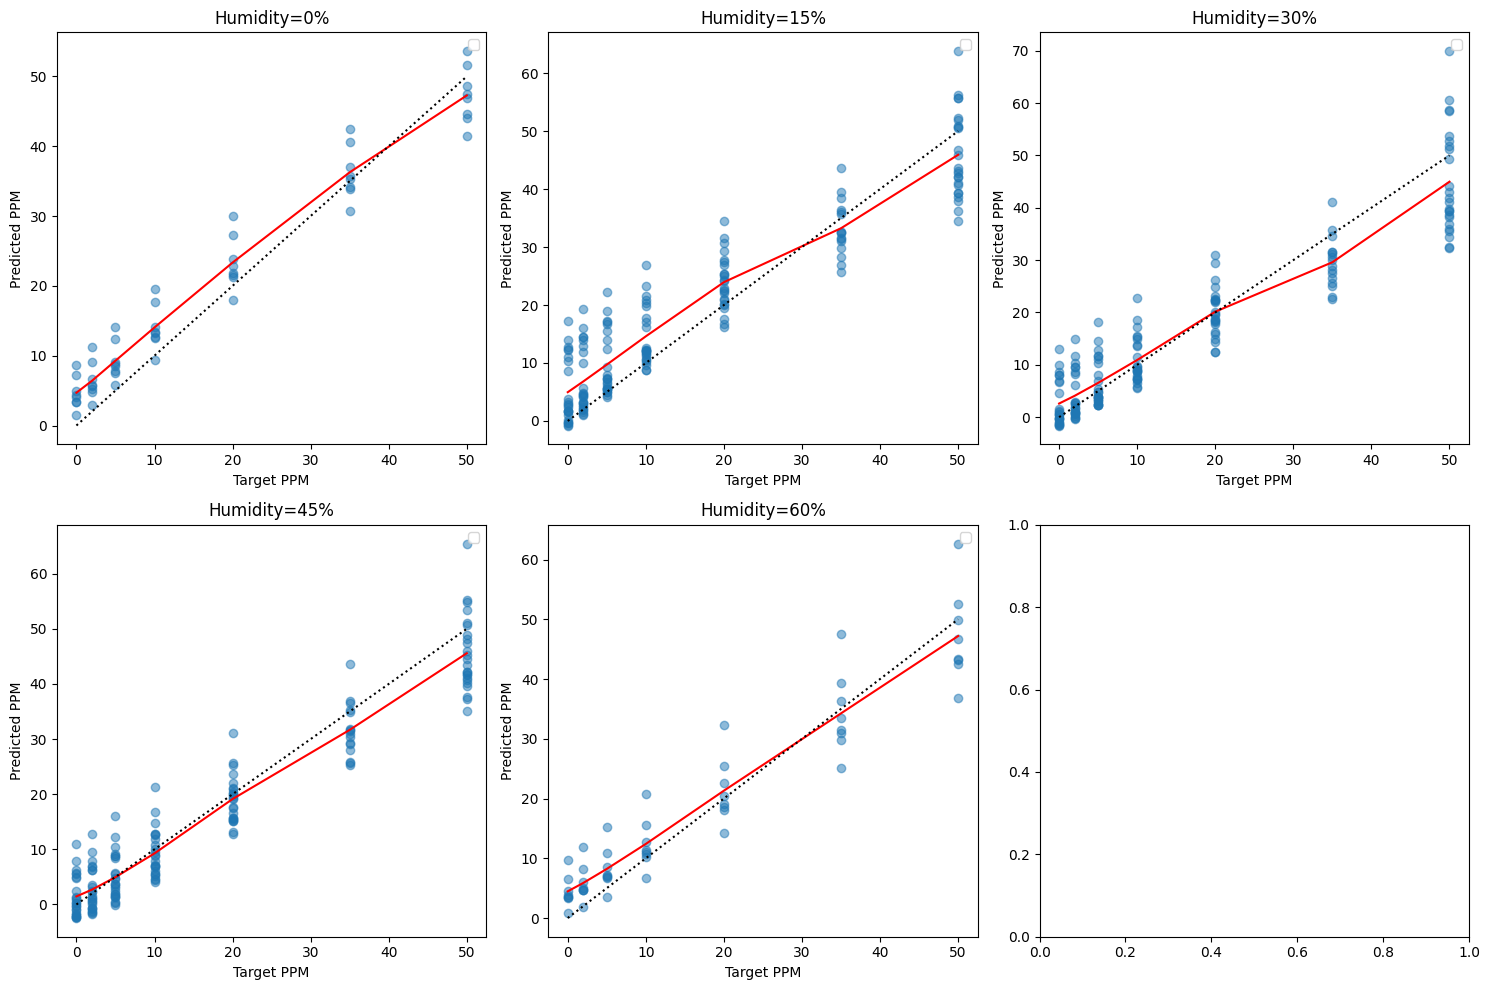

In [64]:
# Funk Equation
# a*R+b
# a*np.exp(-1*R*b+c)+d
# a*R**b+c
# a*R**b+c*H*(a*R**b+c)+d  (Basically Bastviken)
# (a*np.exp(-1*R*b+c)+d)+f*H*(a*np.exp(-1*R*b+c)+d)+g
# a*np.exp(-1*R*b+c)+d*np.exp(-1*H*f+g)+h (Funk Equation)
# a*np.exp((-1*R*b+c)+(-1*H*f+g))+h 4.2
#                                                           W/1000  W/500   UV500   UV1000
# a**((-1*R*b+c)+(-1*H*d+e))+f 6.4                          87.79   42.64   62.74   116.35
# a**((-1*R*b)+(-1*H*c)+d)+e   6.5                          87.79

# a**((((-1*R)/(H**b))*c)+(-1*H*d)+e)+f 7.1                 74.09   35.76   62.37   113.46


# a**((((-1*R)/(H**b))*c)+(-1*H*d)+(-1*T*e)+f)+g 8.1
# a**((((-1*R)/(H**b))*c)+(-1*H*d)+(-1*T*e)+(((-1)/(T*f*H**g))*h)+i)+j 8.2
# a**((((-1*R)/(H**b))*c)+(-1*H*d)+(-1*T*e)+(((-1*T*f)/(H**g))*h)+i)+j 8.3                           5.764

#a**((((-1*R)/(H**b))*c)+(-1*H*d)+(-1*T*e)+(((-1*T*f)/(H**g))*h)+i)+j*np.exp(-1*T*k)+l 9.1


#0.97**((((-1*R)/(H**(-0.66)))*c)+(-1*H)+(1.21*T)+(((-1.22*T)/(H**0.23))*1.25)+-178.26)+j            5.865



def funkEQ(X, a, b):
    R, H, T = X
    with np.errstate(over='ignore'):
        stuff=0.97**((((-1*R)/(H**(-0.66)))*a)+(-1*H)+(1.21*T)+(((-1.22*T)/(H**0.23))*1.25)+-178.26)+b
    return stuff
p0 = 1, 1

def residual(params, X, y):
    return np.sum((y - funkEQ(X, *params))**2)

# Perform curve fitting using the funct function, xDataResistance, and yDataTargetPPM data
# Set the maximum number of function evaluations to 1000000

popt, pcov = sc.curve_fit(funkEQ, (xDataResistance, xDataRH, xDataTemp), yDataTargetPPM, p0, maxfev=1000000)

# Print the optimized parameters as [a b c d e f]
print(popt)

#########
# Getting RMSE of Equation
#########

R_test = X_test.loc[:, 'Resistance']
H_test = X_test.loc[:, 'RelativeHumidity']
T_test = X_test.loc[:, 'Temperature']

# Generate the predictions using the optimized parameters and the input data
y_pred = funkEQ((R_test, H_test, T_test), *popt)

# Calculate the mean squared error
testVal = mean_squared_error(y_test, y_pred, squared=False)
print(testVal)

#########
# All the code needed to display predicted vs actual graphs
#########

from scipy.stats import t

# Degrees of freedom
df = len(yDataTargetPPM) - len(popt)

# Student's t value for the 95% confidence level
t_val = t.ppf(1-0.05/2, df)

# Compute the standard error of the parameters
perr = np.sqrt(np.diag(pcov))

# Compute the standard error of the predictions
def predict_std(X, popt, perr):
    jac = np.array([funkEQ(X, *popt[:i], 1 if j == i else 0, *popt[i+1:]) for i,j in enumerate(range(len(popt)))]).T
    return np.sqrt(np.sum((jac * perr) ** 2, axis=1))

# Compute the 95% confidence intervals for the predicted values
predict_std_val = predict_std((R_test, H_test, T_test), popt, perr)
conf_int_lower = y_pred - t_val * predict_std_val
conf_int_upper = y_pred + t_val * predict_std_val

# break up the points by humidity percentage to show more accurate graphs
humidity_values = [0, 15, 30, 45, 60]  # Updated humidity values

fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # Create a 2x3 grid of subplots for 5 humidities

# Flatten the axs array in case it's 2D
axs = axs.flatten()

for i, H in enumerate(humidity_values):
    # Filter the data for the given humidity value
    mask = (file2['RelativeHumidity'] >= H - 5) & (file2['RelativeHumidity'] <= H + 5)
    df_filtered = file2.loc[mask]

    xDataResistance1 = df_filtered.loc[:, 'Resistance']
    xDataRH1 = df_filtered.loc[:, 'RelativeHumidity']
    xDataTemp1 = df_filtered.loc[:,'Temperature']
    yDataTargetPPM1 = df_filtered.loc[:, 'Target PPM']

    y_pred = funkEQ((xDataResistance1, xDataRH1, xDataTemp1), *popt)
    df_filtered['Predicted PPM'] = y_pred

    # Create a scatter plot
    sc = axs[i].scatter(yDataTargetPPM1, y_pred, alpha=.5)

    # Calculate mean prediction for each target PPM and plot it
    mean_pred_per_target_ppm = df_filtered.groupby('Target PPM')['Predicted PPM'].mean()
    axs[i].plot(mean_pred_per_target_ppm.index, mean_pred_per_target_ppm.values, color='r')

    # Add a linear dotted line
    axs[i].plot(yDataTargetPPM1, yDataTargetPPM1, 'k:')

    axs[i].legend()
    axs[i].set_xlabel('Target PPM')
    axs[i].set_ylabel('Predicted PPM')
    axs[i].set_title(f'Humidity={H}%')

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

#############
#Funk7.1 RMSE: 7.76      R2: 0.776       Note: Works for all humidity tested
#Funk6.5 RMSE: 10.06     R2: 0.49        Note: Does not work for 0% humidity
#Bast    RMSE: 10.12     R2: 0.57        Note: Does Terrible at 0PPM

# a**((((-1*R)/(H**b))*c)+(-1*H*d)+(-1*T*e)+(((-1*T*f)/(H**g))*h)+i)+j #


          A             B             **C**           **D**             **E**         **F**            **G**           **H**            I              J
[     0.97074939   -0.66315841     -1.59269803      1.0536148       -1.21424252      1.21653832      0.23679682      1.25194333    -178.26000596   -3.18564098  ]

[ 9.71159562e-01 -6.64199093e-01 -1.65193120e+00  1.11963674e+00 -2.50605074e+00  1.66382050e+00  8.22882184e-02  1.67439318e+00 -1.81002233e+02 -2.80620571e+00] Sensor 0
[ 9.63056173e-01 -6.82953695e-01 -1.34960040e+00  9.92613769e-01 -2.11797991e+00  1.52369294e+00  1.10584948e-01  1.54433916e+00 -1.44942697e+02 -2.22342189e+00] Sensor 3
[ 9.48139380e-01 -6.79941782e-01 -9.24165423e-01  6.96117499e-01 -5.98266903e+00  2.47273598e+00  2.31827381e-02  2.47209744e+00 -1.01764616e+02 -1.92126651e+00] Sensor 5
[ 7.96799185e-02 -6.91081640e-01 -2.12370951e-02  1.57416783e-02 -9.85814081e+00  3.14033770e+00  3.31005434e-04  3.13925377e+00 -2.23423494e+00 -1.15451938e+00] Sensor 7

9.28890348e-01 -6.67188051e-01 -6.32613441e-01  4.51694602e-01
 -8.86005975e+00  2.99132427e+00  1.06839408e-02  2.99153912e+00
 -7.14093518e+01 -8.14992392e-16  1.87099690e+01 -3.32455194e+00






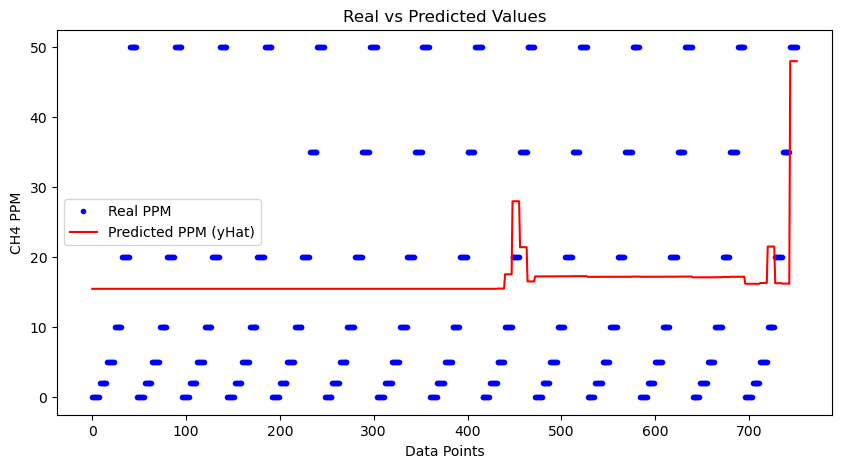

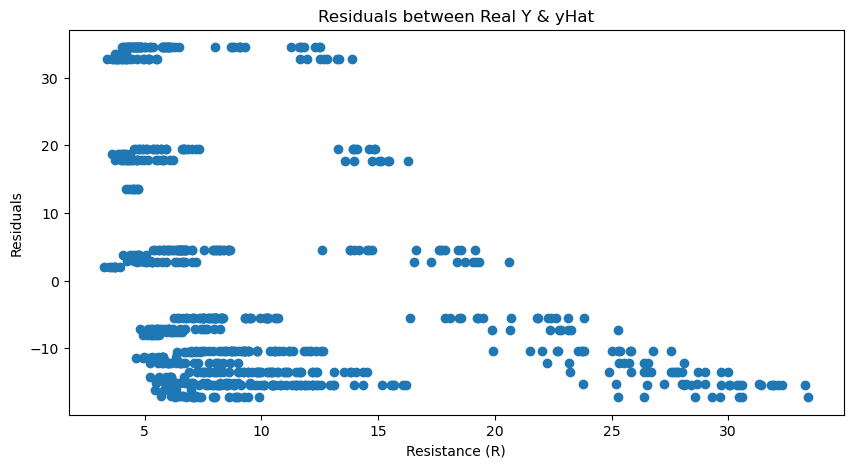

In [58]:
# Extract the X values for the curve fitting
X_values = (xDataResistance, xDataRH, xDataTemp)

# Compute the predicted y values using the optimized parameters
yHat = funkEQ(X_values, *popt)

# Extract the real y values from your data
realY = file2.loc[:, 'Target PPM']

# Compute the residuals
residual = realY - yHat

# Plot the real and predicted y values
plt.figure(figsize=(10, 5))
plt.plot(realY, 'b.', label='Real PPM')
plt.plot(yHat, 'r-', label='Predicted PPM (yHat)')
plt.xlabel('Data Points')
plt.ylabel('CH4 PPM')
plt.title('Real vs Predicted Values')
plt.legend()
plt.show()

# Plot the residuals
plt.figure(figsize=(10, 5))
plt.scatter(xDataResistance, residual)
plt.xlabel('Resistance (R)')
plt.ylabel('Residuals')
plt.title('Residuals between Real Y & yHat')
plt.show()


In [94]:
# Calculate residuals using the training data
residuals = yDataTargetPPM - funkEQ((xDataResistance, xDataRH, xDataTemp), *popt)
residuals_std = np.std(residuals)

# Calculate prediction
prediction = funkEQ([15,50, 20], *popt)

# Calculate the 95% prediction interval
prediction_interval = 1.96 * residuals_std

print("Prediction:", prediction)
print("95% Prediction Interval: [", prediction - prediction_interval, ",", prediction + prediction_interval, "]")


Prediction: -3.135578646679424
95% Prediction Interval: [ -15.548588385982487 , 9.27743109262364 ]


R-squared:  0.867712576251382


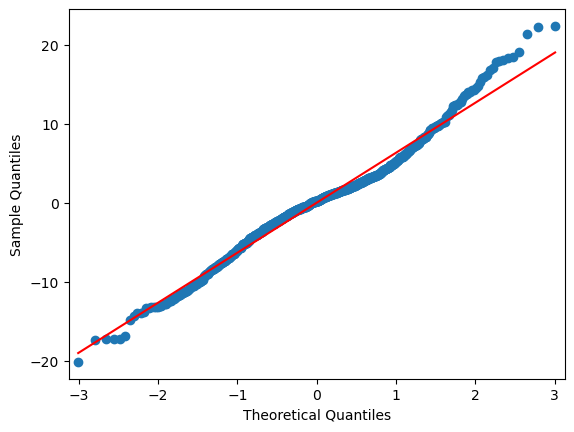

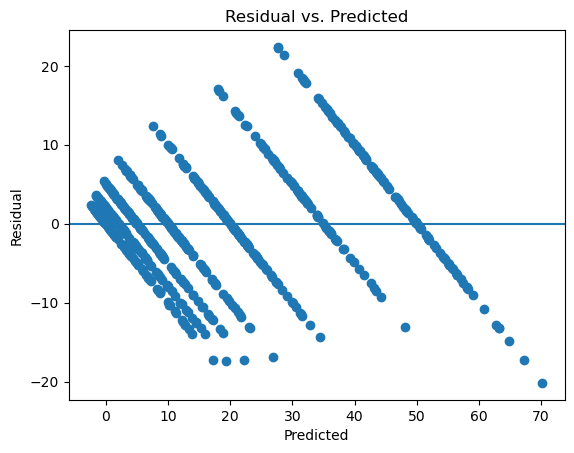

F-statistic: 540.7776435532114
p-value: 6.37784e-319


In [95]:
xDataResistance = file2.loc[:, 'Resistance']
xDataRatio = file2.loc[:, 'Ratio']
xDataRH = file2.loc[:, 'RelativeHumidity']
xDataTemp = file2.loc[:, 'Temperature']
yDataTargetPPM = file2.loc[:, 'Target PPM']

# Separate the independent and dependent variables
X = file2.drop('Target PPM', axis='columns')
y = file2.loc[:, 'Target PPM']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_pred = funkEQ((xDataResistance, xDataRH, xDataTemp), *popt)
print('R-squared: ', r2_score(y, y_pred))

# Calculate residuals
residuals = y - y_pred

# Reshape your input data to fit the het_breuschpagan function requirements
exog = np.vstack((xDataResistance, xDataRH, xDataTemp)).T

# QQ Plot
sm.qqplot(residuals, line='s')
plt.show()

# Residual vs. Predicted plot
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

# First compute the various sum of squares
SST = np.sum((yDataTargetPPM - np.mean(yDataTargetPPM)) ** 2)
SSE = np.sum(residuals ** 2)
SSR = SST - SSE

# Then compute the degree of freedoms
df1 = len(popt) - 1  # number of parameters in your model - 1
df2 = len(yDataTargetPPM) - len(popt)  # number of observations - number of parameters

# Then compute the mean square values
MSR = SSR / df1
MSE = SSE / df2

# Finally compute the F-statistic and the associated p-value
F = MSR / MSE
p_value = f.sf(F, df1, df2)

print('F-statistic:', F)
print('p-value:', p_value)


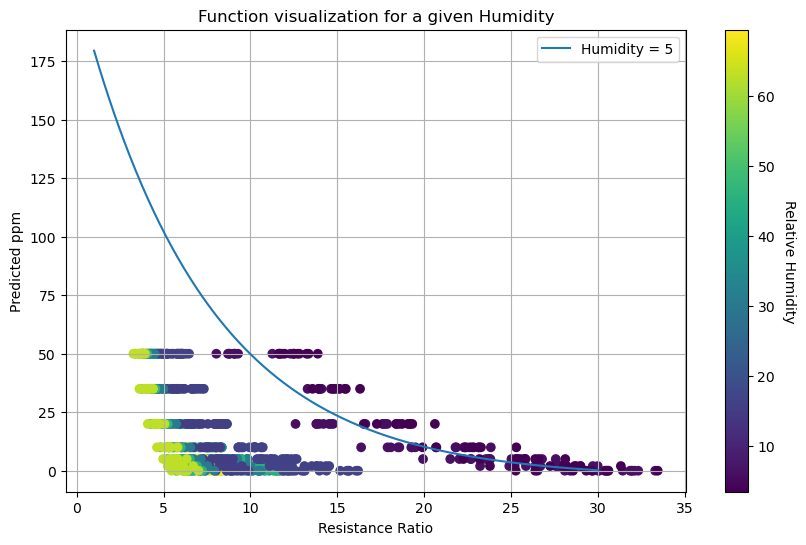

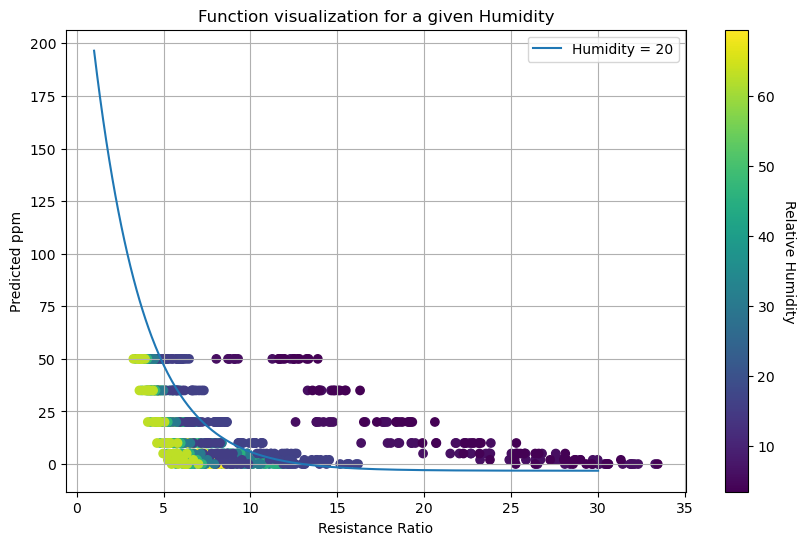

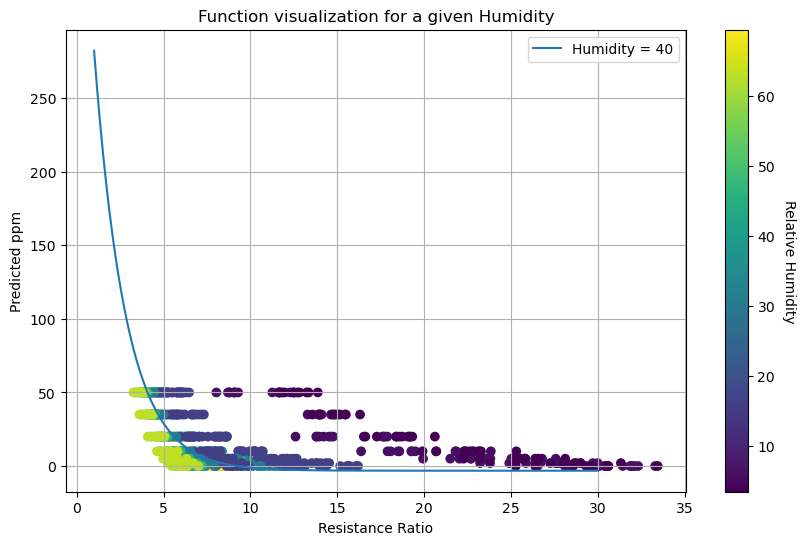

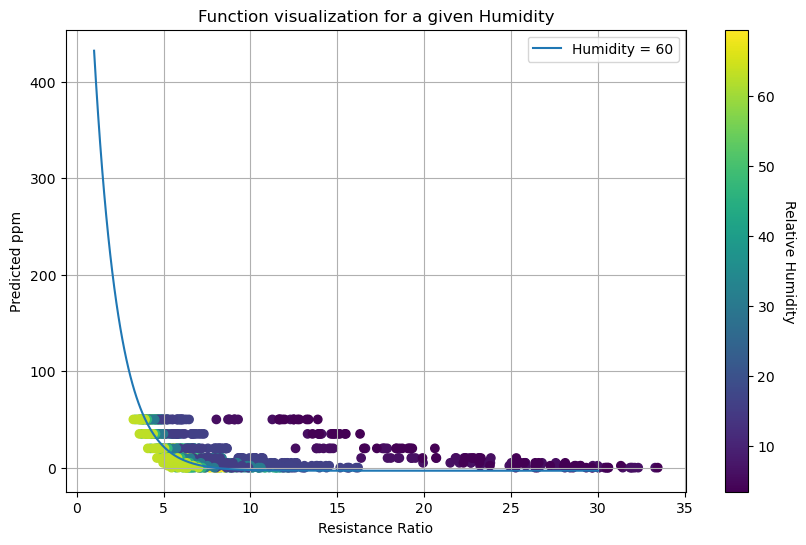

In [96]:
df=file2
# Define colors based on 'RelativeHumidity' column
colors = df.loc[:, 'RelativeHumidity']
R = np.linspace(1, 30, num=500)
for H in [5,20,40,60]:
    # calculate function values
    y_values = [funkEQ((r, H, 20), *popt) for r in R]

    # plotting
    plt.figure(figsize=(10,6))
    scatter = plt.scatter(df.loc[:, 'Resistance'], df.loc[:, "Target PPM"], c=colors, cmap='viridis')
    plt.plot(R, y_values, label=f'Humidity = {H}')
    plt.xlabel('Resistance Ratio')
    plt.ylabel('Predicted ppm')
    plt.title('Function visualization for a given Humidity')
    plt.legend()
    plt.grid(True)

    # Create colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Relative Humidity', rotation=270, labelpad=15)

    plt.show()
